# Voc segmentation

There is a dataset that contains images of objects from different classes — the Pascal Visual Object Classes (VOC). This page applies the UNet architecture to that dataset.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.datasets import VOCSegmentation

import wandb
from PIL import Image
import huggingface_hub
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print("using device", DEVICE)


# Determining where the notebook is run and the corresponding setup. If 
# necessary, load all required credentials.
runned_in_free_server = False

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Runned in Kaggle")
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_token = user_secrets.get_secret("wandb_token")
    hf_token = user_secrets.get_secret("hf_token")
    runned_in_free_server = True

elif 'COLAB_GPU' in os.environ:
    print("Runned in colab")
    from google.colab import userdata
    
    wandb_token = userdata.get("wandb_token")
    hf_token = userdata.get("hf_token")
    runned_in_free_server = True

if runned_in_free_server:
    # Downloading extra source files
    !wget https://raw.githubusercontent.com/fedorkobak/knowledge/refs/heads/main/python/torch/examples/unet/unet.py
 
    wandb.login(key=wandb_token)
    del wandb_token
    
    huggingface_hub.login(hf_token)
    del hf_token

from unet import (
    Up, Down,
    DoubleConv,
    evaluate,
    run_epoch,
    save_model,
    load_model
)

using device cpu


## Dataset

Consider dataset that we will work with.

In [2]:
data_transforms = torchvision.datasets.vision.StandardTransform(
    T.ToTensor(), T.ToTensor()
)

train_dataset = VOCSegmentation(
    root='./voc_segmentation',
    year='2012',
    image_set='train',
    download=True
)
val_dataset = VOCSegmentation(
    root='./voc_segmentation',
    year='2012',
    image_set='val',
    download=True
)

Using downloaded and verified file: ./voc_segmentation/VOCtrainval_11-May-2012.tar
Extracting ./voc_segmentation/VOCtrainval_11-May-2012.tar to ./voc_segmentation
Using downloaded and verified file: ./voc_segmentation/VOCtrainval_11-May-2012.tar
Extracting ./voc_segmentation/VOCtrainval_11-May-2012.tar to ./voc_segmentation


As is typical in a segmentation task, it contains pictures and arrays of the same size as the labels, where each pixel represents the class of that pixel.

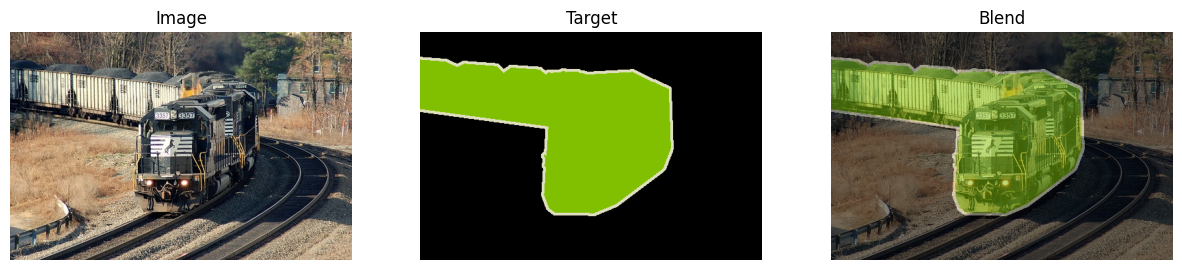

In [3]:
image, target = train_dataset[10]

plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(target)
plt.title("Target")
plt.axis('off')

plt.subplot(133)
plt.imshow(Image.blend(
    im1=image,
    im2=target.convert('RGB'),
    alpha=0.5
))
plt.title("Blend")
plt.axis('off')


plt.show()

I found the following description of the labels for this task:

- 1: Aeroplane
- 2: Bicycle
- 3: Bird
- 4: Boat
- 5: Bottle
- 6: Bus
- 7: Car
- 8: Cat
- 9: Chair
- 10: Cow
- 11: Dining Table
- 12: Dog
- 13: Horse
- 14: Motorbike
- 15: Person
- 16: Potted Plant
- 17: Sheep
- 18: Sofa
- 19: Train
- 20: TV Monitor

But if you check values that are in the target of the arbitrary sample, it will be pictures from 0 to 1, which is not corresponds to the classes description below:

In [4]:
image, target = train_dataset[10]
torch.unique(T.ToTensor()(target))

tensor([0.0000, 0.0745, 1.0000])

The target has to be multiplied by 255 to obtain the labels. The following cell shows the unique numbers and their of the target multiplied by 255 for a purposely selected picture from the training set.

In [5]:
ans = torch.unique(T.ToTensor()(target)*255, return_counts=True)
dict(zip([v.item() for v in ans[0]], [v.item() for v in ans[1]]))

{0.0: 115576, 19.0: 46635, 255.0: 4289}

There are the numbers 0, 19, and 255. The number 19 obviously corresponds to pixels in the train. Based on the counts, it appears that 0 corresponds to the background pixels and 255 corresponds to the border pixels.

According to the information discovered earlier, we are constructing our target values.

In [6]:
transforms = torchvision.datasets.vision.StandardTransform(
    transform=T.Compose([
        T.ToTensor(),
        T.Resize([128, 128], antialias=True),
        T.Lambda(lambda x: x.to(device=DEVICE))
    ]),
    target_transform=T.Compose([
        T.ToTensor(),
        T.Resize([128, 128], antialias=True, interpolation=T.InterpolationMode.NEAREST),
        # After applying `ToTensor`, the target will have one extra dimension
        # for channels, which is ambiguous in this case — that's why we apply 
        # `squeeze`.
        T.Lambda(lambda x: x.squeeze()),
        T.Lambda(lambda x: (x*255).long()),
        T.Lambda(lambda x: torch.where(x==255, 21, x)),
        T.Lambda(lambda x: x.to(device=DEVICE))
    ])
)

train_dataset.transforms = transforms
val_dataset.transforms = transforms

The following cell visualizes the data obtained after all transformations.

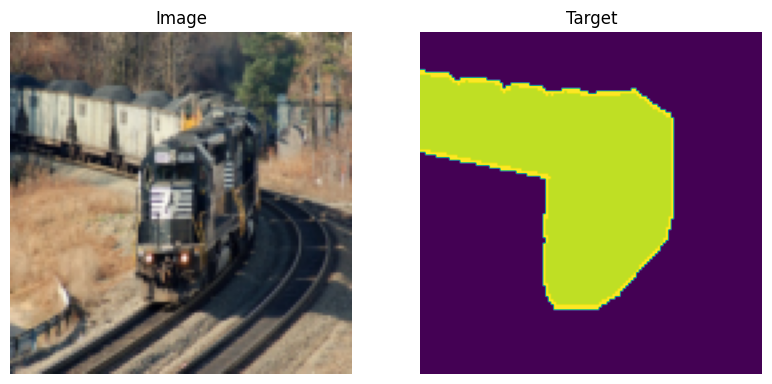

In [7]:
plt.figure(figsize=(15, 10))

input, target = train_dataset[10]

plt.subplot(131)
plt.imshow(T.ToPILImage()(input))
plt.title("Image")
plt.axis(False)

plt.subplot(132)
plt.imshow(target)
plt.title("Target")
plt.axis(False)

plt.show()

Well, the pictures are now significantly smaller, but they are all the same size.

## Model

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, out_channels=32)
        self.down1 = Down(in_channels=32, out_channels=64)
        self.down2 = Down(in_channels=64, out_channels=128)
        self.down3 = Down(in_channels=128, out_channels=256)

        self.bottleneck = Down(in_channels=256, out_channels=256)

        # Input Up layer is concatenation by channels of the previous layer
        # and corresponding down layer
        self.up1 = Up(in_channels=512, out_channels=128)
        self.up2 = Up(in_channels=256, out_channels=64)
        self.up3 = Up(in_channels=128, out_channels=32)
        self.up4 = Up(in_channels=64, out_channels=32)

        # The last layer applies a convolution that preserves the dimensionality
        # of the feature maps and returns as many channels as the number of
        # predicted classes.
        self.outc = torch.nn.Conv2d(
            in_channels=32,
            out_channels=n_classes,
            kernel_size=1
        )

    def forward(self, x):
        x1 = self.inc(x=x)
        x2 = self.down1(x=x1)
        x3 = self.down2(x=x2)
        x4 = self.down3(x=x3)
        x5 = self.bottleneck(x=x4)
        x = self.up1(x=x5, x_left=x4)
        x = self.up2(x=x, x_left=x3)
        x = self.up3(x=x, x_left=x2)
        x = self.up4(x=x, x_left=x1)
        logits = self.outc(x)
        return logits

## Fitting

The following cell realises fitting procedure that was used ot train the model.

In [ ]:
torch.manual_seed(20)

create_model = lambda: UNet(n_channels=3, n_classes=22)
model = create_model()
model.to(DEVICE)

batch_size = 8
learning_rate = 1e-3

wandb.init(
    project="VOCSegmentation",
    config={
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)

loss_fun = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(val_dataset, batch_size=batch_size)
best_test_accuracy = 0

try:
    for epoch in range(50):

        run_epoch(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            optimizer=optimizer
        )
        train_accuracy, train_loss = evaluate(
            model=model,
            loader=train_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate train"
        )
        test_accuracy, test_loss = evaluate(
            model=model,
            loader=test_loader,
            loss_fun=loss_fun,
            tqdm_desc="Evaluate test"
        )

        wandb.log(
            {
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_accuracy": train_accuracy,
                "test_accuracy": test_accuracy
            },
            step=epoch
        )

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model = create_model()
            best_model.load_state_dict(model.state_dict())

except KeyboardInterrupt:
    pass

And finally, here’s how you can save the best model to your Hugging Face account.

In [ ]:
save_model(model=best_model, name="VOCSegmentatoin.pt")

## Evaluating model

In this section, we will load the best model and evaluate its actual performance.

In [10]:
model = load_model(
    model=UNet(n_channels=3, n_classes=22),
    name="VOCSegmentatoin.pt"
)
model = model.eval()

The following cell represents accuracy of the final model.

In [13]:
test_loader = DataLoader(val_dataset, batch_size=64)
accuracy, _ = evaluate(
    model=model,
    loader=test_loader,
    loss_fun=torch.nn.functional.cross_entropy
)
print(f"Accuracy of the model - {accuracy*100}%")

100%|██████████| 23/23 [01:01<00:00,  2.65s/it]

Accuracy of the model - 65.68055152893066%
